In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

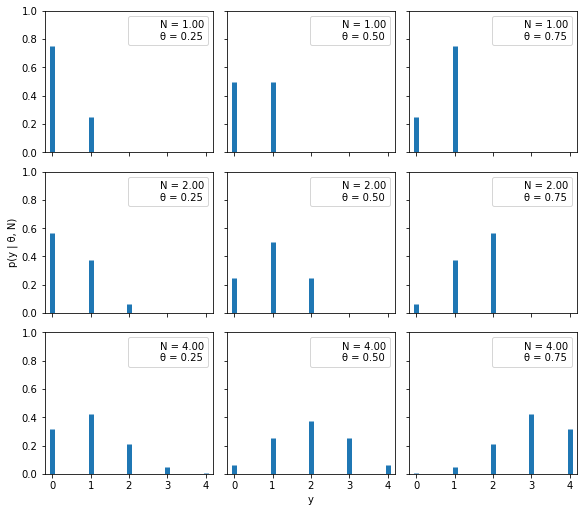

In [2]:
n_params = [1, 2, 4]  # Number of trials
p_params = [0.25, 0.5, 0.75]  # Probability of success

x = np.arange(0, max(n_params)+1)
f,ax = plt.subplots(len(n_params), len(p_params), sharex=True, 
                    sharey=True,
                    figsize=(8, 7), constrained_layout=True)

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]

        y = stats.binom(n=n, p=p).pmf(x)

        ax[i,j].vlines(x, 0, y, colors='C0', lw=5)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].plot(0, 0, label="N = {:3.2f}\nθ = {:3.2f}".format(n,p), alpha=0)
        ax[i,j].legend()

        ax[2,1].set_xlabel('y')
        ax[1,0].set_ylabel('p(y | θ, N)')
        ax[0,0].set_xticks(x)


### Choosing the prior

As a prior we will use a beta distribution, which is a very common distribution:

\begin{equation}
p\left(\theta\right) = \frac{\Gamma\left(\alpha+\beta\right)}{\Gamma\left(\alpha\right)\Gamma\left(\beta\right)}\theta^(\alpha - 1)\left(1-\theta\right)^{\beta -1}
\end{equation}

The beta distribution is a common choice of prior in Bayesian statistics:

Text(0.07, 0.5, 'p(θ)')

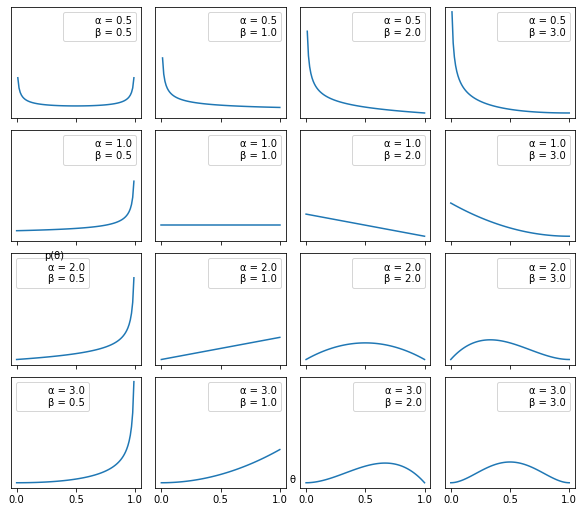

In [3]:
params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, 
                     sharey=True,
                     figsize=(8, 7), constrained_layout=True)
for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = stats.beta(a, b).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a, 
                     b), alpha=0)
        ax[i,j].legend()
ax[1,0].set_yticks([])
ax[1,0].set_xticks([0, 0.5, 1])
f.text(0.5, 0.05, 'θ', ha='center')
f.text(0.07, 0.5, 'p(θ)', va='center', rotation=0)

A beta distribution is a conjugate prior of the binomial distribution. A conjugate prior of a likelihood is a prior, when used in combination with a given likelihod, returns a posterior with the same functional form as the prior. e.g. if we use the beta distribution as our likelihood function then if our prior is a binomial distribution so will our posterior be.

## Getting the posterior

\begin{equation}
p\left(\theta | y\right) \propto \frac{N!}{y!\left(N-y\right)!}\theta^y\left(1-\theta\right)^{N-y}\frac{\Gamma\left(\alpha+\beta\right)}{\Gamma\left(\alpha\right)\Gamma\left(\beta\right)}\theta^{\alpha - 1}\left(1-\theta\right)^{\beta -1}
\end{equation}

## Computing and plotting the posterior

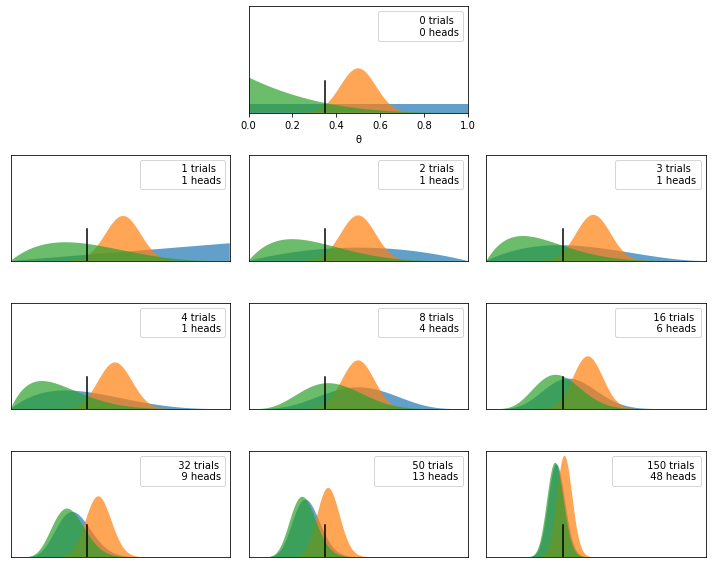

In [4]:
plt.figure(figsize=(10, 8))

n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta_real = 0.35

beta_params = [(1, 1), (20, 20), (1, 4)]
dist = stats.beta
x = np.linspace(0, 1, 200)

for idx, N in enumerate(n_trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
        plt.xlabel('θ')
    else:
        plt.subplot(4, 3, idx+3)
        plt.xticks([])
    y = data[idx]
    for (a_prior, b_prior) in beta_params:
        p_theta_given_y = dist.pdf(x, a_prior + y, b_prior + N - y)
        plt.fill_between(x, 0, p_theta_given_y, alpha=0.7)

    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label=f'{N:4d} trials\n{y:4d} heads', alpha=0)
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.legend()
    plt.yticks([])
plt.tight_layout()

## Highest Posterior Density (HPD)



In [5]:
import arviz as az

array([<AxesSubplot:title={'center':'θ'}>], dtype=object)

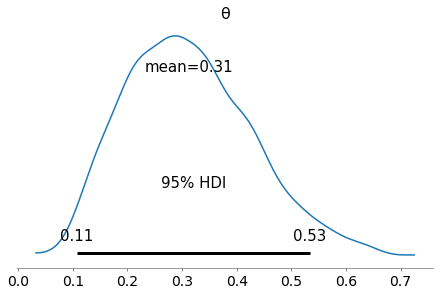

In [6]:
np.random.seed(1)
az.plot_posterior({'θ':stats.beta.rvs(5, 11, size=1000)}, credible_interval=0.95)

# Trying PyMC3

### Flipping some coins

In [7]:
# Get some fake coin flip data
np.random.seed(123)
trials = 4
theta_real = 0.35 # unknown value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=trials)

In [8]:
# Let us import pymc3
import pymc3 as pm

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [9]:
with pm.Model() as our_first_model:
    θ = pm.Beta('θ', alpha=1., beta=1.)
    y = pm.Bernoulli('y', p=θ, observed=data)
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8834800167483259, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

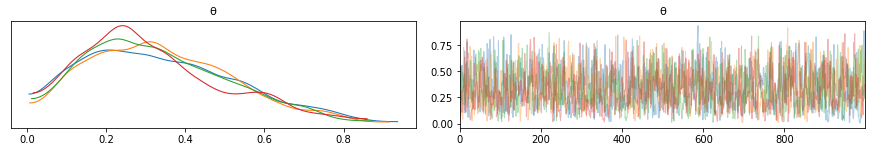

In [10]:
az.plot_trace(trace)

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.331,0.18,0.023,0.656,0.005,0.003,1430.0,1430.0,1354.0,1668.0,1.0


array([<AxesSubplot:title={'center':'θ'}>], dtype=object)

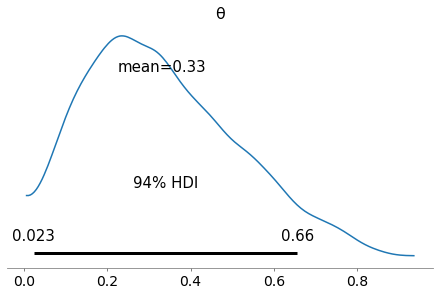

In [12]:
az.plot_posterior(trace)

## ROPE (Region of Practical Equivalence)

array([<AxesSubplot:title={'center':'θ'}>], dtype=object)

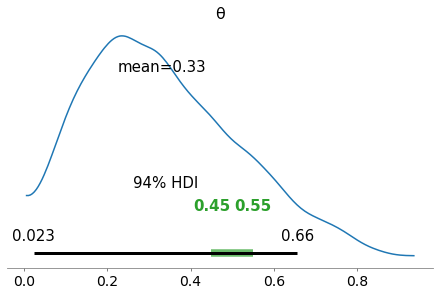

In [13]:
az.plot_posterior(trace, rope=[0.45, 0.55])

## Reference Value

We can also check againsts a reference value to compare with 

array([<AxesSubplot:title={'center':'θ'}>], dtype=object)

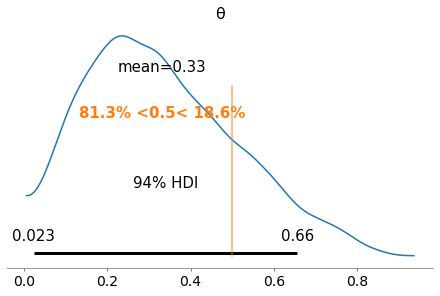

In [14]:
az.plot_posterior(trace, ref_val=0.5)

## Loss functions

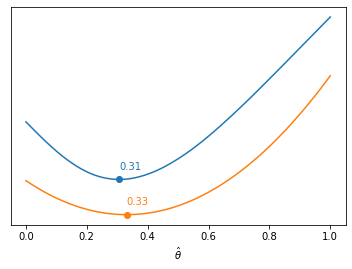

In [15]:
grid = np.linspace(0, 1, 200)
θ_pos = trace['θ']
lossf_a = [np.mean(abs(i - θ_pos)) for i in grid]
lossf_b = [np.mean((i - θ_pos)**2) for i in grid]

for lossf, c in zip([lossf_a, lossf_b], ['C0', 'C1']):
    mini = np.argmin(lossf)
    plt.plot(grid, lossf, c)
    plt.plot(grid[mini], lossf[mini], 'o', color=c)
    plt.annotate('{:.2f}'.format(grid[mini]),
                 (grid[mini], lossf[mini] + 0.03), color=c)
    plt.yticks([])
    plt.xlabel(r'$\hat \theta$')

The first value is equal to the median of the posterior and the second value is equal to the mean of the posterior.

In [20]:
np.median(θ_pos)

0.3079597324065309

In [21]:
np.mean(θ_pos)


0.33113512743140744

This basically implies that different loss functions corresponds to different point estimates.